In [202]:
import os, sys
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [203]:
# load all the .csv files within one folder
# return -> dict: {key=csv filename, value=pd.DataFrame}
def load_all_files(path):
    d = {}
    idx = 0
    for root, dirs, files in os.walk(path):
        if idx == 1:
            break
        for file in files:
            d[file.split(".")[0]] = pd.read_csv(os.path.join(root, file), index_col=0)
        idx += 1
    return d

In [204]:
data_dict = load_all_files("./country_csv/")

In [205]:
# selected country iso codes to run linear regression
selected_country = ["GBR"]

In [206]:
# insert the value of the yesterday new cases
def insert_yesterday(df):
    yesterday = [0]
    yesterday.extend(list(df["new_cases"]))
    df["Yesterday"] =yesterday[:-1]
    return df

In [207]:
def do_regression(country, concat_df, standarize=True, verbose=False):
     # clear out invalid tail data       
    concat_df = concat_df.iloc[:-1,:].copy()
    
    # insert "YesterdayConfirmed" feature
    concat_df = insert_yesterday(concat_df).copy()
    
    # replace NaN with 0
    concat_df = concat_df.fillna(0)
    
    features = concat_df.columns[1:]
    print(features)
    
    # create train&test data
    # whether to scale the data, True by default
    if standarize:
        scaler = MinMaxScaler(feature_range=(0,1))
#         X = concat_df.values
        X = scaler.fit_transform(concat_df.values)
        y = X[:,0]
#         print(y[-10:])
        X = X[:,1:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        X_train = np.hstack((np.ones(X_train.shape[0]).reshape(-1,1), X_train))
        X_test = np.hstack((np.ones(X_test.shape[0]).reshape(-1,1), X_test))
    else:
        X = np.array(concat_df.iloc[:,1:])
        y = np.array(concat_df.iloc[:,0]).reshape(-1,1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # create linear regression model & train
#     regr = linear_model.LinearRegression()
    regr = Ridge(alpha=1.5)
#     regr = Lasso(alpha=0.001)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    
    if verbose:
        # print out statistical data
        print("--------------------------------------------------")
        print("Country:", country)
        print('Coefficients: \n')
        for i in range(0, len(regr.coef_) -1):
            print("Feature: %s" % features[i])
            print("Weight: %.6f" % regr.coef_[i+1])
        print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
        print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
        print(len(features))
        print(len(regr.coef_))
        plt.plot(y_pred, label = "y_pred", color="red");
        plt.plot(y_test, label = "y_test", color="blue");
        plt.legend()
        plt.show()
    return regr.coef_[1:]

In [208]:
# prepare statistical dict for coefs
coefs = {}
for k in data_dict.keys():
    coefs[k] = []

Calculating: GBR 0
Index(['total_deaths', 'reproduction_rate', 'total_tests', 'positive_rate',
       'tests_per_case', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'life_expectancy',
       'human_development_index', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'St

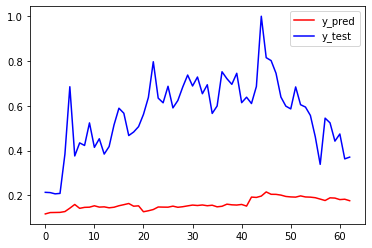

In [209]:
idx = 0
verbose=True
for country in selected_country:
    print("Calculating:", country, idx)
    c = do_regression(country, data_dict[country], verbose=verbose)
    if not verbose:
        for k in range(len(c)):
            coefs[selected_features[k]].append(c[k])
        idx += 1